# Traffic Light Classifier
---

In this project, you’ll use your knowledge of computer vision techniques to build a classifier for images of traffic lights! You'll be given a dataset of traffic light images in which one of three lights is illuminated: red, yellow, or green.

In this notebook, you'll pre-process these images, extract features that will help us distinguish the different types of images, and use those features to classify the traffic light images into three classes: red, yellow, or green. The tasks will be broken down into a few sections:

1. **Loading and visualizing the data**. 
      The first step in any classification task is to be familiar with your data; you'll need to load in the images of traffic lights and visualize them!

2. **Pre-processing**. 
    The input images and output labels need to be standardized. This way, you can analyze all the input images using the same classification pipeline, and you know what output to expect when you eventually classify a *new* image.
    
3. **Feature extraction**. 
    Next, you'll extract some features from each image that will help distinguish and eventually classify these images.
   
4. **Classification and visualizing error**. 
    Finally, you'll write one function that uses your features to classify *any* traffic light image. This function will take in an image and output a label. You'll also be given code to determine the accuracy of your classification model.    
    
5. **Evaluate your model**.
    To pass this project, your classifier must be >90% accurate and never classify any red lights as green; it's likely that you'll need to improve the accuracy of your classifier by changing existing features or adding new features. I'd also encourage you to try to get as close to 100% accuracy as possible!
    
Here are some sample images from the dataset (from left to right: red, green, and yellow traffic lights):
<img src="images/all_lights.png" width="50%" height="50%">


---
### *Here's what you need to know to complete the project:*

Some template code has already been provided for you, but you'll need to implement additional code steps to successfully complete this project. Any code that is required to pass this project is marked with **'(IMPLEMENTATION)'** in the header. There are also a couple of questions about your thoughts as you work through this project, which are marked with **'(QUESTION)'** in the header. Make sure to answer all questions and to check your work against the [project rubric](https://review.udacity.com/#!/rubrics/1213/view) to make sure you complete the necessary classification steps!

Your project submission will be evaluated based on the code implementations you provide, and on two main classification criteria.
Your complete traffic light classifier should have:
1. **Greater than 90% accuracy**
2. ***Never* classify red lights as green**


# 1. Loading and Visualizing the Traffic Light Dataset

This traffic light dataset consists of 1484 number of color images in 3 categories - red, yellow, and green. As with most human-sourced data, the data is not evenly distributed among the types. There are:
* 904 red traffic light images
* 536 green traffic light images
* 44 yellow traffic light images

*Note: All images come from this [MIT self-driving car course](https://selfdrivingcars.mit.edu/) and are licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).*

### Import resources

Before you get started on the project code, import the libraries and resources that you'll need.

In [1]:
import cv2 # computer vision library
import helpers # helper functions

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for loading in images

import skimage
from skimage import feature
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Training and Testing Data

All 1484 of the traffic light images are separated into training and testing datasets. 

* 80% of these images are training images, for you to use as you create a classifier.
* 20% are test images, which will be used to test the accuracy of your classifier.
* All images are pictures of 3-light traffic lights with one light illuminated.

## Define the image directories

First, we set some variables to keep track of some where our images are stored:

    IMAGE_DIR_TRAINING: the directory where our training image data is stored
    IMAGE_DIR_TEST: the directory where our test image data is stored

In [2]:
# Image data directories
IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST = "traffic_light_images/test/"

## Load the datasets

These first few lines of code will load the training traffic light images and store all of them in a variable, `IMAGE_LIST`. This list contains the images and their associated label ("red", "yellow", "green"). 

You are encouraged to take a look at the `load_dataset` function in the helpers.py file. This will give you a good idea about how lots of image files can be read in from a directory using the [glob library](https://pymotw.com/2/glob/). The `load_dataset` function takes in the name of an image directory and returns a list of images and their associated labels. 

For example, the first image-label pair in `IMAGE_LIST` can be accessed by index: 
``` IMAGE_LIST[0][:]```.


In [3]:
# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TRAINING)

## Visualize the Data

The first steps in analyzing any dataset are to 1. load the data and 2. look at the data. Seeing what it looks like will give you an idea of what to look for in the images, what kind of noise or inconsistencies you have to deal with, and so on. This will help you understand the image dataset, and **understanding a dataset is part of making predictions about the data**.

---
### Visualize the input images

Visualize and explore the image data! Write code to display an image in `IMAGE_LIST`:
* Display the image
* Print out the shape of the image 
* Print out its corresponding label

See if you can display at least one of each type of traffic light image – red, green, and yellow — and look at their similarities and differences.

(62, 28, 3) red
(34, 22, 3) green
(83, 50, 3) yellow
(90, 57, 3) red
(107, 47, 3) green
(102, 58, 3) yellow


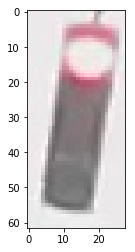

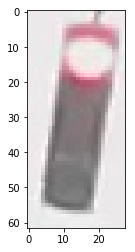

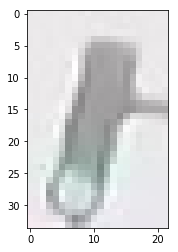

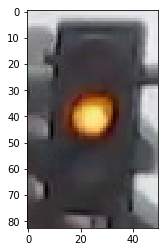

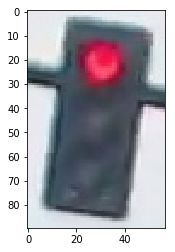

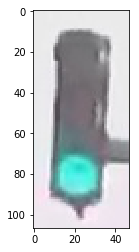

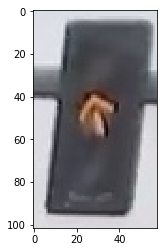

In [4]:
## TODO: Write code to display an image in IMAGE_LIST (try finding a yellow traffic light!)
## TODO: Print out 1. The shape of the image and 2. The image's label
def get_image(color, data, bRandom=False):
    idx = list(range(len(data)))

    #if bRandom is false then first image with color label is displayed, ow randomly image is selected
    if bRandom:
        random.shuffle(idx)
    
    for i in idx:
        image = data[i][0]
        label = data[i][1]
        if label == color:
            break
            
    return image, label

def display_image(color, data, bRandom=False):
    image, label = get_image(color, data, bRandom)
    plt.figure()
    plt.imshow(image)
    print(image.shape, label)

# The first image in IMAGE_LIST is displayed below (without information about shape or label)
selected_image = IMAGE_LIST[0][0]
plt.imshow(selected_image)

display_image("red", IMAGE_LIST)
display_image("green", IMAGE_LIST)
display_image("yellow", IMAGE_LIST)
display_image("red", IMAGE_LIST, True)
display_image("green", IMAGE_LIST, True)
display_image("yellow", IMAGE_LIST, True)

# 2. Pre-process the Data

After loading in each image, you have to standardize the input and output!

### Input

This means that every input image should be in the same format, of the same size, and so on. We'll be creating features by performing the same analysis on every picture, and for a classification task like this, it's important that **similar images create similar features**! 

### Output

We also need the output to be a label that is easy to read and easy to compare with other labels. It is good practice to convert categorical data like "red" and "green" to numerical data.

A very common classification output is a 1D list that is the length of the number of classes - three in the case of red, yellow, and green lights - with the values 0 or 1 indicating which class a certain image is. For example, since we have three classes (red, yellow, and green), we can make a list with the order: [red value, yellow value, green value]. In general, order does not matter, we choose the order [red value, yellow value, green value] in this case to reflect the position of each light in descending vertical order.

A red light should have the  label: [1, 0, 0]. Yellow should be: [0, 1, 0]. Green should be: [0, 0, 1]. These labels are called **one-hot encoded labels**.

*(Note: one-hot encoding will be especially important when you work with [machine learning algorithms](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)).*

<img src="images/processing_steps.png" width="80%" height="80%">


---
<a id='task2'></a>
### (IMPLEMENTATION): Standardize the input images

* Resize each image to the desired input size: 32x32px.
* (Optional) You may choose to crop, shift, or rotate the images in this step as well.

It's very common to have square input sizes that can be rotated (and remain the same size), and analyzed in smaller, square patches. It's also important to make all your images the same size so that they can be sent through the same pipeline of classification steps!

In [5]:
# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    
    ## TODO: Resize image and pre-process so that all "standard" images are the same size  
    standard_im = np.copy(image)
    standard_im = skimage.transform.resize(standard_im, (32, 32), anti_aliasing=True)
    
    return standard_im
    

## Standardize the output

With each loaded image, we also specify the expected output. For this, we use **one-hot encoding**.

* One-hot encode the labels. To do this, create an array of zeros representing each class of traffic light (red, yellow, green), and set the index of the expected class number to 1. 

Since we have three classes (red, yellow, and green), we have imposed an order of: [red value, yellow value, green value]. To one-hot encode, say, a yellow light, we would first initialize an array to [0, 0, 0] and change the middle value (the yellow value) to 1: [0, 1, 0].


---
<a id='task3'></a>
### (IMPLEMENTATION): Implement one-hot encoding

In [6]:
## TODO: One hot encode an image label
## Given a label - "red", "green", or "yellow" - return a one-hot encoded label

# Examples: 
# one_hot_encode("red") should return: [1, 0, 0]
# one_hot_encode("yellow") should return: [0, 1, 0]
# one_hot_encode("green") should return: [0, 0, 1]

def one_hot_encode(label):
    
    ## TODO: Create a one-hot encoded label that works for all classes of traffic lights
    one_hot_encoded = [int(label == "red"), int(label == "yellow"), int(label == "green")] 
    
    return one_hot_encoded


### Testing as you Code

After programming a function like this, it's a good idea to test it, and see if it produces the expected output. **In general, it's good practice to test code in small, functional pieces, after you write it**. This way, you can make sure that your code is correct as you continue to build a classifier, and you can identify any errors early on so that they don't compound.

All test code can be found in the file `test_functions.py`. You are encouraged to look through that code and add your own testing code if you find it useful!

One test function you'll find is: `test_one_hot(self, one_hot_function)` which takes in one argument, a one_hot_encode function, and tests its functionality. If your one_hot_label code does not work as expected, this test will print ot an error message that will tell you a bit about why your code failed. Once your code works, this should print out TEST PASSED.

In [7]:
# Importing the tests
import test_functions
tests = test_functions.Tests()

# Test for one_hot_encode function
tests.test_one_hot(one_hot_encode)


**<span style="color: green;">TEST PASSED</span>**

## Construct a `STANDARDIZED_LIST` of input images and output labels.

This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and one-hot encoded labels.

This uses the functions you defined above to standardize the input and output, so those functions must be complete for this standardization to work!


In [8]:
def standardize(image_list):
    
    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # One-hot encode the label
        one_hot_label = one_hot_encode(label)    

        # Append the image, and it's one hot encoded label to the full, processed list of image data 
        standard_list.append((standardized_im, one_hot_label, item[2]))
        
    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

## Visualize the standardized data

Display a standardized image from STANDARDIZED_LIST and compare it with a non-standardized image from IMAGE_LIST. Note that their sizes and appearance are different!

[1, 0, 0]


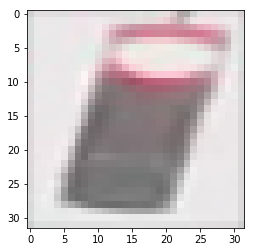

In [9]:
## TODO: Display a standardized image and its label
plt.imshow(STANDARDIZED_LIST[0][0])
print(STANDARDIZED_LIST[0][1])

# 3. Feature Extraction

You'll be using what you now about color spaces, shape analysis, and feature construction to create features that help distinguish and classify the three types of traffic light images.

You'll be tasked with creating **one feature** at a minimum (with the option to create more). The required feature is **a brightness feature using HSV color space**:

1. A brightness feature.
    - Using HSV color space, create a feature that helps you identify the 3 different classes of traffic light.
    - You'll be asked some questions about what methods you tried to locate this traffic light, so, as you progress through this notebook, always be thinking about your approach: what works and what doesn't?

2. (Optional): Create more features! 

Any more features that you create are up to you and should improve the accuracy of your traffic light classification algorithm! One thing to note is that, to pass this project you must **never classify a red light as a green light** because this creates a serious safety risk for a self-driving car. To avoid this misclassification, you might consider adding another feature that specifically distinguishes between red and green lights.

These features will be combined near the end of his notebook to form a complete classification algorithm.

## Creating a brightness feature 

There are a number of ways to create a brightness feature that will help you characterize images of traffic lights, and it will be up to you to decide on the best procedure to complete this step. You should visualize and test your code as you go.

Pictured below is a sample pipeline for creating a brightness feature (from left to right: standardized image, HSV color-masked image, cropped image, brightness feature):

<img src="images/feature_ext_steps.png" width="70%" height="70%">


## RGB to HSV conversion

Below, a test image is converted from RGB to HSV colorspace and each component is displayed in an image.

Label [red, yellow, green]: [1, 0, 0]


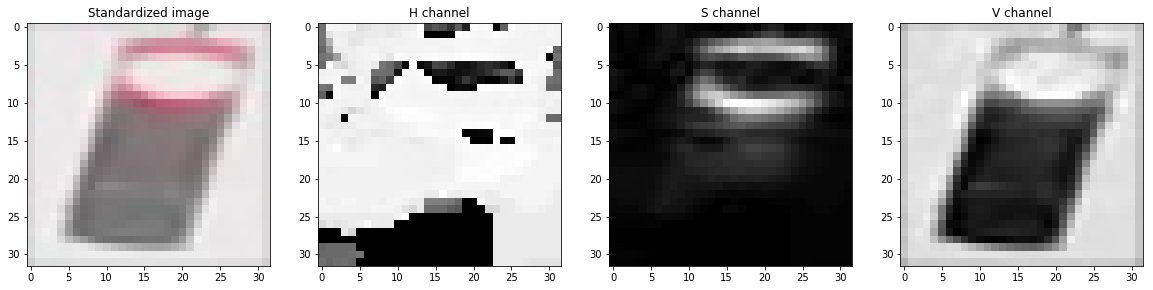

In [10]:
# Convert and image to HSV colorspace
# Visualize the individual color channels

image_num = 0
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]

# Convert to HSV
hsv = skimage.color.rgb2hsv(test_im)

# Print image label
print('Label [red, yellow, green]: ' + str(test_label))

# HSV channels
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

# Plot the original image and the three channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.set_title('Standardized image')
ax1.imshow(test_im)
ax2.set_title('H channel')
ax2.imshow(h, cmap='gray')
ax3.set_title('S channel')
ax3.imshow(s, cmap='gray')
ax4.set_title('V channel')
ax4.imshow(v, cmap='gray')

---
<a id='task7'></a>
### (IMPLEMENTATION): Create a brightness feature that uses HSV color space

Write a function that takes in an RGB image and returns a 1D feature vector and/or single value that will help classify an image of a traffic light. The only requirement is that this function should apply an HSV colorspace transformation, the rest is up to you. 

From this feature, you should be able to estimate an image's label and classify it as either a red, green, or yellow traffic light. You may also define helper functions if they simplify your code.

In [11]:
def hog_features(img, ori, ppc, cpb, doSqrt=False, fv=True, mch=False, vis=False):
    return feature.hog(img, 
                       orientations=ori, 
                       pixels_per_cell=ppc, 
                       cells_per_block=cpb,
                       transform_sqrt=doSqrt,
                       visualize=vis,
                       feature_vector=fv,
                       multichannel=mch)


## TODO: Create a brightness feature that takes in an RGB image and outputs a feature vector and/or value
## This feature should use HSV colorspace values
def create_feature(hsv_image):
    
    ## TODO: Create and return a feature value and/or vector
    feats = hog_features(hsv_image[:,:,2], 9, (8, 8), (2, 2))
    return feats

##### (Optional) Create more features to help accurately label the traffic light images

In [12]:
# (Optional) Add more image analysis and create more features
def create_sv_hog_feature(hsv_image):
    feats = hog_features(hsv_image[:,:,1:], 9, (8, 8), (2, 2), mch=True)
    return feats

def create_hs_hist_feature(hsv_image, nbins=32):
    hist1 = np.histogram(hsv_image[:,:,0], bins=nbins)[0]
    hist1 = hist1/hist1.sum()
    hist2 = np.histogram(hsv_image[:,:,1], bins=nbins)[0]
    hist2 = hist2/hist2.sum()
    return np.concatenate([hist1, hist2])

def create_block_hs_hist_feature(hsv_image, ppc=(8, 8), nbins=16):
    n_cells_row = int(hsv_image.shape[0] // ppc[0])  # number of cells along row-axis
    n_cells_col = int(hsv_image.shape[1] // ppc[1])  # number of cells along col-axis
    block_hist = np.zeros((n_cells_row, n_cells_col, nbins*2))
    
    for r in range(n_cells_row):
        for c in range(n_cells_col):
            st_r = r*ppc[0]
            st_c = c*ppc[1]
            hist = np.histogram(hsv_image[st_r:st_r+ppc[0], st_c:st_c+ppc[1],0], bins=nbins)[0]
            hist = hist/hist.sum()
            block_hist[r, c, :nbins] = hist
            hist = np.histogram(hsv_image[st_r:st_r+ppc[0], st_c:st_c+ppc[1],1], bins=nbins)[0]
            hist = hist/hist.sum()
            block_hist[r, c, nbins:] = hist
    return block_hist.ravel()

def create_block_RGB_hist_feature(rgb_image, ppc=(8, 8), nbins=16):
    n_cells_row = int(rgb_image.shape[0] // ppc[0])  # number of cells along row-axis
    n_cells_col = int(rgb_image.shape[1] // ppc[1])  # number of cells along col-axis
    block_hist = np.zeros((n_cells_row, n_cells_col, nbins*3))
    
    for r in range(n_cells_row):
        for c in range(n_cells_col):
            st_r = r*ppc[0]
            st_c = c*ppc[1]
            for ch in range(3):
                hist = np.histogram(rgb_image[st_r:st_r+ppc[0], st_c:st_c+ppc[1],ch], bins=nbins)[0]
                hist = hist/hist.sum()
                st = ch*nbins
                block_hist[r, c, st:st+nbins] = hist
    return block_hist.ravel()

/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


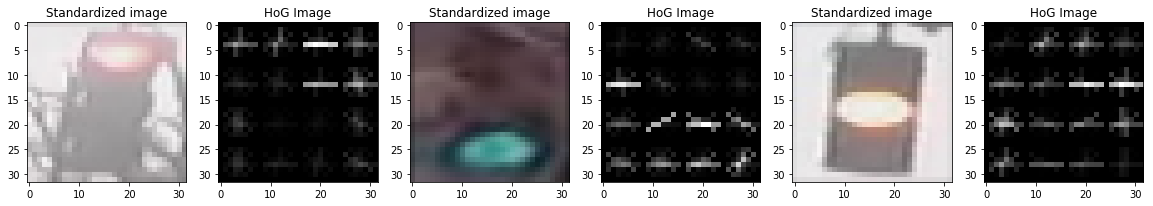

In [13]:
labels = ["red", "green", "yellow"]

images = []
hog_images = []
for l in range(len(labels)):
    image, label = get_image(one_hot_encode(labels[l]), STANDARDIZED_LIST, True)
    images.append(image)
    hsv_image = skimage.color.rgb2hsv(image)
    _, hog_image = hog_features(np.copy(hsv_image), 9, (8, 8), (2, 2), mch=True, vis=True)
    hog_images.append(hog_image)

f, axes = plt.subplots(1, 6, figsize=(20,10))
ax = axes.ravel()
for i in range(len(images)):
    ax[2*i].set_title('Standardized image')
    ax[2*i].imshow(images[i])
    ax[2*i+1].set_title('HoG Image')
    ax[2*i+1].imshow(hog_images[i], cmap='gray')

## (QUESTION 1): How do the features you made help you distinguish between the 3 classes of traffic light images?

**Answer:**
Write your answer in this cell.
<img src="images/hog_features.png" width="100%" height="100%">
<img src="images/hog_features2.png" width="100%" height="100%">

HOG captures edge or gradient structure that is very characteristic of local shape. HOG feature computes the distribution of gradient intensity and orientation on densely overlapped cells and blocks, so the image can be better described for shape and appearance. HOG is relatively invariant to local geometric (scale & rotation within cells) and photometric transformations (illumination invariance by normalization of the cells across larger regions incorporating multiple cells i.e blocks)
Images attached illustrate


HOG feature descriptors are then fed to a linear SVM classifier for classifying traffic lights


# 4. Classification and Visualizing Error

Using all of your features, write a function that takes in an RGB image and, using your extracted features, outputs whether a light is red, green or yellow as a one-hot encoded label. This classification function should be able to classify any image of a traffic light!

You are encouraged to write any helper functions or visualization code that you may need, but for testing the accuracy, make sure that this `estimate_label` function returns a one-hot encoded label.

---
<a id='task8'></a>
### (IMPLEMENTATION): Build a complete classifier 

In [14]:
def get_image_feature(hsv_image, rgb_image, feat_type):
    if feat_type == 'hs_hist':
        return create_hs_hist_feature(hsv_image)
    
    if feat_type == 'block_hs_hist':
        return create_block_hs_hist_feature(hsv_image)
    
    if feat_type == 'block_rgb_hist':
        return create_block_RGB_hist_feature(rgb_image)

    if feat_type == 'hog_sv':
        return create_sv_hog_feature(hsv_image)
    
    if feat_type == 'hog_brightness':
        return create_feature(hsv_image)
    
    feats = []
    return feats

def get_image_features(rgb_image, feat_list):
    ## TODO: Convert image to HSV color space
    hsv_image = skimage.color.rgb2hsv(rgb_image)

    image_feats = []
    for f in range(len(feat_list)):
        image_feats.append(get_image_feature(np.copy(hsv_image), np.copy(rgb_image), feat_list[f]))
       
    return np.concatenate(image_feats)
    
def standardize_features(features):
    sScaler = StandardScaler().fit(features) # Fit a per-column scaler
    std_features = sScaler.transform(features) # Apply the scaler to features
    return std_features
    
def get_all_features(data, feat_list):
    idx = list(range(len(data)))
    random.shuffle(idx)
    
    labels = []
    features = []
    files = []
    
    for i in idx:
        image, one_hot_label, file = data[i]
        label = one_hot_label[0]+one_hot_label[1]*2+one_hot_label[2]*3
        labels.append(label)
        files.append(file)
        features.append(get_image_features(image, feat_list))        

    return features, labels, files


# Train the classifier
# hog_brightness & hog_hsv shud be used mutually exclusively
feat_list = ['hog_brightness']
xTrain, yTrain, _ = get_all_features(STANDARDIZED_LIST, feat_list)
clf = svm.SVC(kernel='linear')
clf.fit(xTrain, yTrain)

/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
# This function should take in RGB image input
# Analyze that image using your feature creation code and output a one-hot encoded label
def estimate_label(rgb_image, feat_list, clf):
    
    ## TODO: Extract feature(s) from the RGB image and use those features to
    ## classify the image and output a one-hot encoded label
    image_feat = get_image_features(rgb_image, feat_list)
    lPred = clf.predict([image_feat])[0]
    predicted_label = [0, 0, 0]
    predicted_label[lPred-1] = 1    

    return predicted_label    

## Testing the classifier

Here is where we test your classification algorithm using our test set of data that we set aside at the beginning of the notebook! This project will be complete once you've pogrammed a "good" classifier.

A "good" classifier in this case should meet the following criteria (and once it does, feel free to submit your project):
1. Get above 90% classification accuracy.
2. Never classify a red light as a green light. 

### Test dataset

Below, we load in the test dataset, standardize it using the `standardize` function you defined above, and then **shuffle** it; this ensures that order will not play a role in testing accuracy.


In [16]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TEST)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:1

In [17]:
xTest, yTest, files = get_all_features(STANDARDIZED_TEST_LIST, feat_list)
yPred = clf.predict(xTest)
print("Accuracy: "+str(accuracy_score(yTest, yPred)))
print('\n')
print(classification_report(yTest, yPred))

/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


Accuracy: 0.996632996633


             precision    recall  f1-score   support

          1       1.00      1.00      1.00       181
          2       1.00      0.89      0.94         9
          3       0.99      1.00      1.00       107

avg / total       1.00      1.00      1.00       297



## Determine the Accuracy

Compare the output of your classification algorithm (a.k.a. your "model") with the true labels and determine the accuracy.

This code stores all the misclassified images, their predicted labels, and their true labels, in a list called `MISCLASSIFIED`. This code is used for testing and *should not be changed*.

In [18]:
# Constructs a list of misclassified images given a list of test images and their labels
# This will throw an AssertionError if labels are not standardized (one-hot encoded)

def get_misclassified_images(test_images, feat_list, clf):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]
        assert(len(true_label) == 3), "The true_label is not the expected length (3)."

        # Get predicted label from your classifier
        predicted_label = estimate_label(im, feat_list, clf)
        assert(len(predicted_label) == 3), "The predicted_label is not the expected length (3)."

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label, image[2]))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST, feat_list, clf)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))


/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


Accuracy: 0.9966329966329966
Number of misclassified images = 1 out of 297


In [19]:
for i in range(len(MISCLASSIFIED)):
    print(MISCLASSIFIED[i][3], MISCLASSIFIED[i][2],MISCLASSIFIED[i][1])

traffic_light_images/test/yellow/2f2fcecc-d118-454b-96e0-4018f584bf0a.jpg [0, 1, 0] [0, 0, 1]


---
<a id='task9'></a>
### Visualize the misclassified images

Visualize some of the images you classified wrong (in the `MISCLASSIFIED` list) and note any qualities that make them difficult to classify. This will help you identify any weaknesses in your classification algorithm.

[0, 0, 1]


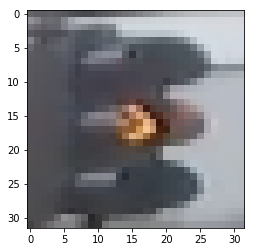

In [20]:
# Visualize misclassified example(s)
## TODO: Display an image in the `MISCLASSIFIED` list 
## TODO: Print out its predicted label - to see what the image *was* incorrectly classified as
if len(MISCLASSIFIED) > 0:
    n = 0
    plt.imshow(MISCLASSIFIED[n][0])
    print(MISCLASSIFIED[n][1])

/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


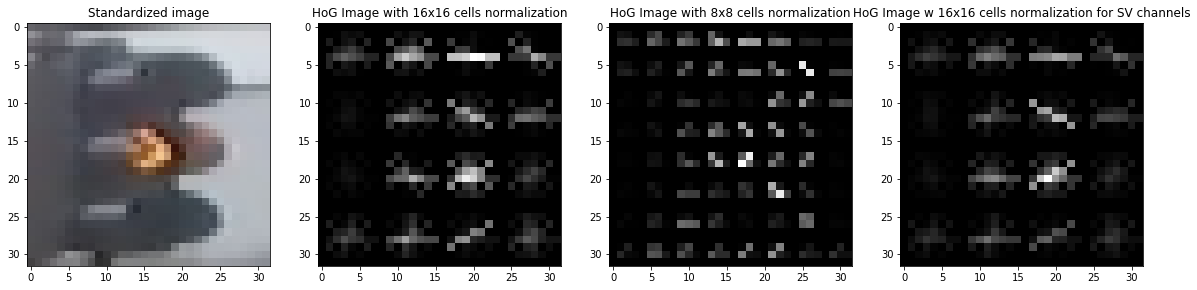

In [21]:
if len(MISCLASSIFIED) > 0:
    hsv_image = skimage.color.rgb2hsv(MISCLASSIFIED[n][0])
    _, hog_image1 = hog_features(np.copy(hsv_image[:, :, 2]), 9, (8, 8), (2, 2), vis=True)
    _, hog_image2 = hog_features(np.copy(hsv_image[:, :, 2]), 9, (4, 4), (2, 2), vis=True)
    _, hog_image3 = hog_features(np.copy(hsv_image[:, :, 1:]), 9, (8, 8), (2, 2), mch=True, vis=True)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.set_title('Standardized image')
    ax1.imshow(MISCLASSIFIED[n][0])
    ax2.set_title('HoG Image with 16x16 cells normalization')
    ax2.imshow(hog_image1, cmap='gray')
    ax3.set_title('HoG Image with 8x8 cells normalization')
    ax3.imshow(hog_image2, cmap='gray')
    ax4.set_title('HoG Image w 16x16 cells normalization for SV channels')
    ax4.imshow(hog_image3, cmap='gray')

---
<a id='question2'></a>
## (Question 2): After visualizing these misclassifications, what weaknesses do you think your classification algorithm has? Please note at least two.

**Answer:** Write your answer in this cell.

Above gives an accuracy of 0.9966329966329966

<img src="images/hog_features_misclassified.png" width="100%" height="100%">

A - Smaller structures/shapes r missed as can be seen by decreasing the cell size and blocks used for normalization. However this will increase the feature vector size which may not be desirable

B - Gradients in the saturation channel are missed. Max gradient computation from S/V channels may help keeping the size of feature vector same

C - It does not consider the color information of the traffic lights. Color histogram of patches can be integrated with HOG features to better classify

## Test if you classify any red lights as green

**To pass this project, you must not classify any red lights as green!** Classifying red lights as green would cause a car to drive through a red traffic light, so this red-as-green error is very dangerous in the real world. 

The code below lets you test to see if you've misclassified any red lights as green in the test set. **This test assumes that `MISCLASSIFIED` is a list of tuples with the order: [misclassified_image, predicted_label, true_label].**

Note: this is not an all encompassing test, but its a good indicator that, if you pass, you are on the right track! This iterates through your list of misclassified examples and checks to see if any red traffic lights have been mistakenly labelled [0, 1, 0] (green).

In [22]:
# Importing the tests
import test_functions
tests = test_functions.Tests()

if(len(MISCLASSIFIED) > 0):
    # Test code for one_hot_encode function
    tests.test_red_as_green(MISCLASSIFIED)
else:
    print("MISCLASSIFIED may not have been populated with images.")


**<span style="color: green;">TEST PASSED</span>**

# 5. Improve your algorithm!

**Submit your project after you have completed all implementations, answered all questions, AND when you've met the two criteria:**
1. Greater than 90% accuracy classification
2. No red lights classified as green

If you did not meet these requirements (which is common on the first attempt!), revisit your algorithm and tweak it to improve light recognition -- this could mean changing the brightness feature, performing some background subtraction, or adding another feature!

---

In [23]:
# Train the classifier
feat_list = ['hog_sv']
xTrain, yTrain, _ = get_all_features(STANDARDIZED_LIST, feat_list)
clf = svm.SVC(kernel='linear')
clf.fit(xTrain, yTrain)

# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST, feat_list, clf)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


Accuracy: 1.0
Number of misclassified images = 0 out of 297


### Going Further (Optional Challenges)

If you found this challenge easy, I suggest you go above and beyond! Here are a couple **optional** (meaning you do not need to implement these to submit and pass the project) suggestions:
* (Optional) Aim for >95% classification accuracy.
* (Optional) Some lights are in the shape of arrows; further classify the lights as round or arrow-shaped.
* (Optional) Add another feature and aim for as close to 100% accuracy as you can get!